In [24]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.15.0


In [25]:
(X_train, y_train) , (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [26]:
num_classes = len(np.unique(y_train))
category = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

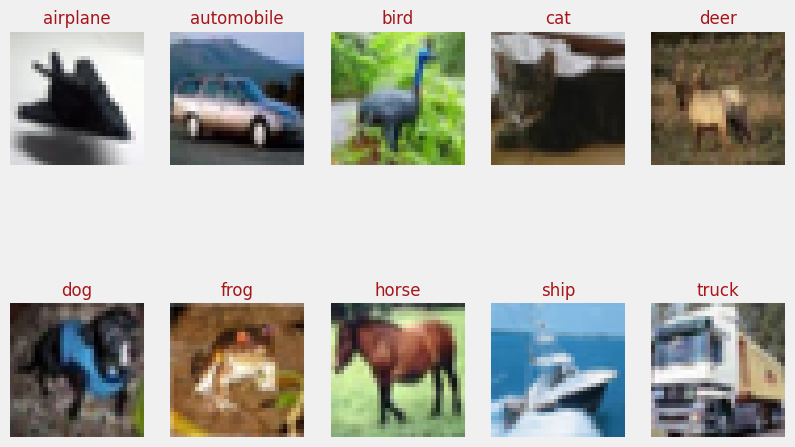

In [27]:
#plotting the image of every class
plt.figure(figsize = (10,10))
for i in range (num_classes):
    axs = plt.subplot(3, 5, i+1)
    idx = np.where(y_train[:]==i)[0]
    x = X_train[idx,::]
    plt.imshow(x[0])
    axs.set_title(category[i])
    plt.axis("off")

In [28]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [29]:
X_train = preprocess_image_input(X_train)
X_test = preprocess_image_input(X_test)

In [30]:
'''
ResNet50, pre-trained on ImageNet weights, conducts feature extraction. The input size is 224 x 224 pixels.
'''
def feature_extractor(inputs):

  extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return extractor


In [31]:
'''
Specifies the final dense layers followed by a softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [32]:
'''
Begin by upsampling the input image by a factor of (7x7) to convert it to a size of (224 x 224).
Then, proceed to integrate the feature extraction and "classifier" layers to construct the model.
'''
def model_final(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_1 = classifier(resnet_feature_extractor)

    return classification_1


In [33]:
'''
Construct the model and compile it.
Utilize Stochastic Gradient Descent as the optimizer and Sparse Categorical CrossEntropy as the loss function.
'''
def compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_2 = model_final(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_2)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098

In [34]:
EPOCHS = 3
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_test, y_test), batch_size=64)

Epoch 1/3
782/782 [==============================] - 181s 212ms/step - loss: 0.4046 - accuracy: 0.8676 - val_loss: 0.2234 - val_accuracy: 0.9252
Epoch 2/3
782/782 [==============================] - 165s 211ms/step - loss: 0.1018 - accuracy: 0.9669 - val_loss: 0.1816 - val_accuracy: 0.9416
Epoch 3/3
782/782 [==============================] - 165s 211ms/step - loss: 0.0349 - accuracy: 0.9893 - val_loss: 0.1793 - val_accuracy: 0.9466


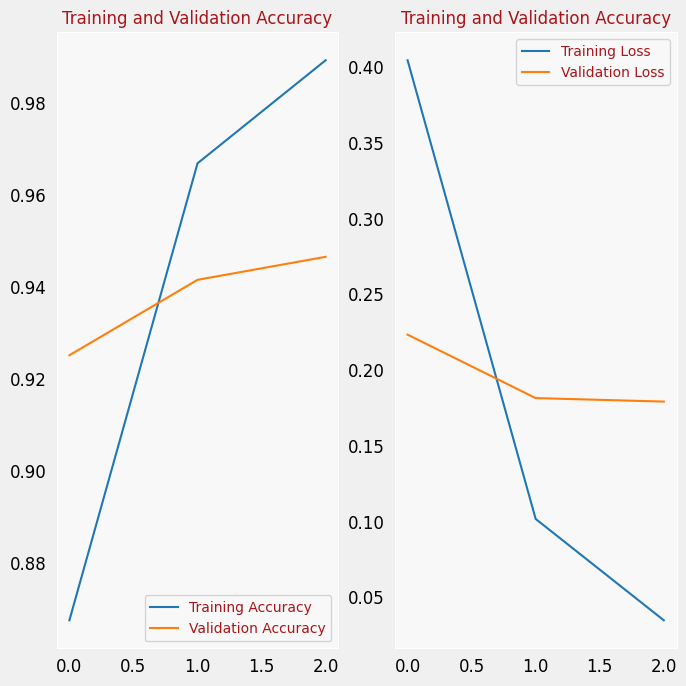

In [35]:
#plotting the loss and accuracy curve

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')
plt.show()

In [36]:
evaluation = model.evaluate(X_test, y_test)
print('Test Accuracy of Base Model: {}'.format(evaluation[1]))

313/313 [==============================] - 10s 31ms/step - loss: 0.1793 - accuracy: 0.9466
Test Accuracy of Base Model: 0.9466000199317932


In [37]:
predict = model.predict(X_test)
print(predict)
predLabel = np.argmax(predict, axis=1)
print(predLabel)

313/313 [==============================] - 10s 28ms/step


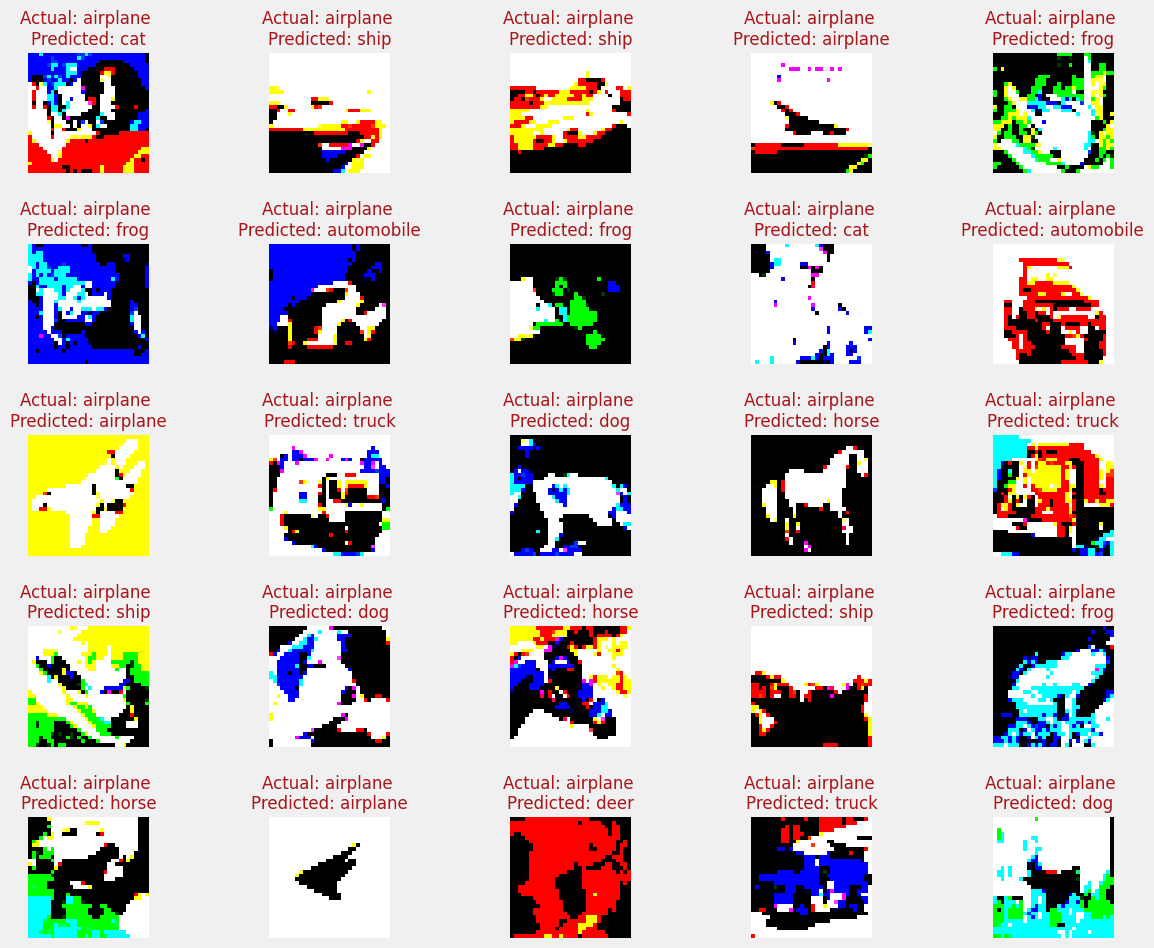

In [38]:
# Evaluate the model against test images to perform predictions

fi, ax = plt.subplots(5, 5, figsize=(14,12))
ax = ax.ravel()

for i in np.arange(0, 25):
    ax[i].imshow(X_test[i])
    ax[i].set_title("Actual: %s \nPredicted: %s" % (category[np.argmax(y_test[i])], category[predLabel[i]] ))
    ax[i].axis('off')
    plt.subplots_adjust(wspace=1)